### Introduction

Two classification tests on the CEGS001 L1000 dataset. We can either:
  1. Predict whether or not a patient has SCZ
  2. Predict which perturbagen was used on a sample
from the gene expression profile.

In [88]:
%load_ext autoreload
%autoreload 2

from lib import models, graph, coarsening, utils
import os, networkx, pickle, scipy, lib, time
import numpy as np, matplotlib, matplotlib.pyplot as plt, pandas as pd, tensorflow as tf
import gene_expression_modelling.parse_cmap as pcmp
from gene_expression_modelling.constants import *
from gene_expression_modelling.utils import *
import ml_toolkit.pandas_constructions as pdc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.calibration import calibration_curve
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier

%matplotlib inline

plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (15, 15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
def show_calibration(clfs):
    plt.figure(figsize=(15, 15))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in clfs:
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        elif type(clf) == lib.models.cgcnn:
            prob_pos = clf.class_probabilities(X_test_perm)
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % (name, ))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    plt.show()

# 1 Data

We'll load the CEGS001 Dataset, and two possible graphs we can use.

In [63]:
BASE_DATA_DIR = '/scratch/mmd/project_run_files/CEGS_clustering/data'
SUPPL_DATA_DIR = '/scratch/mmd/gene_expression_modelling/gene_expression_modelling/data'
EXP_DIR = os.path.join(BASE_DATA_DIR, 'Experiment 4 (CEGS001)/')
CTRLS = [d for d in os.listdir(EXP_DIR) if '177' in d or '179' in d or '8330' in d]
SCZS = [d for d in os.listdir(EXP_DIR) if '170' in d or '215' in d]

CORR_GRAPH_FILE = os.path.join(BASE_DATA_DIR, 'gene_self_correlation.pkl')
REG_GRAPH_FILE = os.path.join(SUPPL_DATA_DIR, 'gene_regulatory_network.pkl')

HEALTHY = 0
SCZ = 1
DX_COL = 'diagnosis'

corr_graph = depickle(CORR_GRAPH_FILE)
reg_graph = depickle(REG_GRAPH_FILE)

In [64]:
def restrict_indices(df): 
    return pdc.keep_indices(df, index_levels=['cell_id', 'pert_name', 'pert_dose'],
                            column_levels=['pr_gene_symbol'])
def get_df(d):
    base = os.path.join(EXP_DIR, d, 'by_rna_well')
    path = next((d for d in os.listdir(base) if '_COMPZ.MODZ_SCORE_LM_' in d))
    return restrict_indices(pcmp.parse(os.path.join(base, path)))

In [65]:
ctrls = pd.concat([get_df(ctrl) for ctrl in CTRLS])
ctrls[DX_COL] = HEALTHY
ctrls.set_index(DX_COL, inplace=True, append=True)
sczs = pd.concat([get_df(scz) for scz in SCZS])
sczs[DX_COL] = SCZ
sczs.set_index(DX_COL, inplace=True, append=True)

X_raw = pd.concat([ctrls, sczs])
nodelist = X_raw.columns.get_level_values('pr_gene_symbol')
X_scaled = pd.DataFrame(data=scale(X_raw.values), index=X_raw.index, columns=X_raw.columns)

/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [66]:
def get_components(G):
    all_components = [comp for comp in networkx.components.connected_component_subgraphs(G)]
    all_nodelists = [[n for n in component.nodes()] for component in all_components]
    nontrivial_components, final_nodelists, disconnected_nodes = [], [], []
    for component, nodelist in zip(all_components, all_nodelists):
        if len(nodelist) <= 10: disconnected_nodes += nodelist
        else:
            nontrivial_components.append(component)
            final_nodelists.append(nodelist)
    return nontrivial_components, final_nodelists, disconnected_nodes
    
def flatten(L): return L[0] if len(L) == 1 else L[0] + flatten(L[1:])

In [67]:
SG_corr = networkx.Graph([(u,v,d) for u,v,d in corr_graph.edges(data=True) if d['weight'] > 0.5])
SG_corr.add_nodes_from(nodelist)
corr_components, corr_nodelists, corr_disconnected_nodes = get_components(SG_corr)
total_corr_nodelist = flatten(corr_nodelists) + corr_disconnected_nodes

reg_components, reg_nodelists, reg_disconnected_nodes = get_components(reg_graph)
total_reg_nodelist = flatten(reg_nodelists) + reg_disconnected_nodes

In [68]:
X_no_graph = X_scaled.copy()
dx_y = X_no_graph.index.get_level_values(DX_COL)
drug_y = LabelEncoder().fit_transform(X_no_graph.index.get_level_values(PERT_NAME_COL))

X_corr = X_scaled[total_corr_nodelist]
X_reg  = X_scaled[total_reg_nodelist]

assert (X_no_graph.index == X_corr.index).all() and (X_no_graph.index == X_reg.index).all()

In [69]:
X_corr.columns

Index(['CRK', 'MTHFD2', 'ABCF3', 'PIP4K2B', 'STAMBP', 'CDKN1B', 'CSNK1A1',
       'DDX42', 'LSM5', 'SLC35B1',
       ...
       'PSMB10', 'FGFR4', 'CDKN2A', 'TRAM2', 'NCOA3', 'FOSL1', 'MLLT11',
       'CEBPZ', 'GAPDH', 'CBR3'],
      dtype='object', name='pr_gene_symbol', length=978)

In [70]:
X_reg.columns

Index(['ARNT2', 'FAM20B', 'MAPKAPK5', 'BCL2', 'ATF5', 'DFFA', 'TFAP2A',
       'REEP5', 'HEATR1', 'PLA2G4A',
       ...
       'UFM1', 'VPS72', 'WFS1', 'WIPF2', 'WRB', 'XPNPEP1', 'YKT6', 'ZDHHC6',
       'ZNF586', 'ZW10'],
      dtype='object', name='pr_gene_symbol', length=978)

In [71]:
def plot_many_adj_matricies(Ms):
    N = len(Ms)
    width = int(np.ceil(np.sqrt(N)))
    
    subplot_str = lambda i: '{width}{width}{i}'.format(width=width, i=i)
    for i, M in enumerate(Ms):
        ax = plt.subplot(subplot_str(i))
        ax.spy(M, markersize=0.5, color='black')
        ax.set_title('Correlation Graph')

    plt.show()

In [72]:
corr_params = {
    'dir_name': 'gcnn_drug_classifier_corr',
    'num_epochs': 300,
    'batch_size': 20,
    'eval_frequency': 100,

    # Building blocks.
    'filter': 'chebyshev5',
    'brelu': 'b1relu',
    'pool': 'apool1',

    # Architecture.
    'F': [10, 10],  # Number of graph convolutional filters.
    'K': [35, 35],  # Polynomial orders.
    'p': [2, 2],    # Pooling sizes.
    'M': [100, max(drug_y) + 1],  # Output dimensionality of fully connected layers.

    # Optimization.
    'regularization': 1e-2,
    'dropout': 0.5,
    'learning_rate': 6e-3,
    'decay_rate': 0.98,
    'momentum': 0.9,
}

In [50]:
reg_params = {
    'dir_name': 'gcnn_drug_classifier_reg',
    'num_epochs': 500,
    'batch_size': 20,
    'eval_frequency': 100,

    # Building blocks.
    'filter': 'chebyshev5',
    'brelu': 'b1relu',
    'pool': 'apool1',

    # Architecture.
    'F': [8, 8],  # Number of graph convolutional filters.
    'K': [40, 40],  # Polynomial orders.
    'p': [2, 2],    # Pooling sizes.
    'M': [100, C],  # Output dimensionality of fully connected layers.

    # Optimization.
    'regularization': 1e-2,
    'dropout': 0.5,
    'learning_rate': 6e-3,
    'decay_rate': 0.983,
    'momentum': 0.9,
    'decay_steps': 2*X_train.shape[0] / 20,
}

In [73]:
BASE_PARAMS = {
    'num_epochs': 300,
    'batch_size': 20,
    'eval_frequency': 100,

    # Building blocks.
    'filter': 'chebyshev5',
    'brelu': 'b1relu',
    'pool': 'apool1',

    # Optimization.
    'regularization': 1e-2,
    'dropout': 0.5,
    'learning_rate': 6e-3,
    'decay_rate': 0.98,
    'momentum': 0.9,
    'decay_steps': 400,
}

In [128]:
def train_graph_net(
    X, y, components, nodelists, disconnected_nodes,
    levels           = 3,
    self_connections = False,
    normalized       = True,
    base_params      = BASE_PARAMS,
    update_params    = {}
):
    assert 'dir_name' in update_params and type(update_params['dir_name']) == str,\
    "dir_name must be provided (and must be a string)"
    
    X_train, X_val, X_test, y_train, y_val, y_test = pdc.split([X, y], dev_size=0.08)
    num_components = len(components)

    print("Train Shape: ", X_train.shape, y_train.shape)
    print("Dev Shape: ", X_val.shape, y_val.shape)
    print("Test Shape: ", X_test.shape, y_test.shape)
    print("Num Components: ", num_components)
    
    adjacency_matricies = [
        networkx.adjacency_matrix(c, nodelist=n).astype(np.float32) for c, n in zip(components, nodelists)
    ]
    plot_many_adj_matricies(adjacency_matricies)
    
    graphs, Ls, perms, X_trains, X_vals, X_tests = [], [], [], [], [], []
    for component, nodelist, A in zip(range(num_components), nodelists, adjacency_matricies):
        print("Analyzing component %d with %d nodes" % (component, len(nodelist)))
        gs, perm = coarsening.coarsen(A, levels=3, self_connections=False)
        Ls.append([graph.laplacian(g, normalized=normalized) for g in gs])
        graphs.append(gs)
        perms.append(perm)
        X_trains.append(coarsening.perm_data(X_train[nodelist].copy().values, perm).astype(np.float32))
        X_vals.append(coarsening.perm_data(X_val[nodelist].copy().values, perm).astype(np.float32))
        X_tests.append(coarsening.perm_data(X_test[nodelist].copy().values, perm).astype(np.float32))
    
    X_trains.append(X_train[disconnected_nodes].values.astype(np.float32))
    X_vals.append(X_val[disconnected_nodes].values.astype(np.float32))
    X_tests.append(X_test[disconnected_nodes].values.astype(np.float32))
    
    for c in range(num_components):
        assert X_trains[c].shape[1] == X_vals[c].shape[1]
        assert X_vals[c].shape[1] == X_tests[c].shape[1]
    for df_list in [X_trains, X_vals, X_tests]:
        num_samples = df_list[0].shape[0]
        for df in df_list: assert df.shape[0] == num_samples
    
    params = base_params.copy()
    params.update(update_params)
    
    m = models.cgcnn_components(Ls=Ls, num_disconnected_nodes=len(disconnected_nodes), **params)
    return m.fit_components(X_trains, y_train, X_vals, y_val), m, (X_trains, X_vals, X_tests)

Train Shape:  (1393, 978) (1393,)
Dev Shape:  (122, 978) (122,)
Test Shape:  (379, 978) (379,)
Num Components:  2


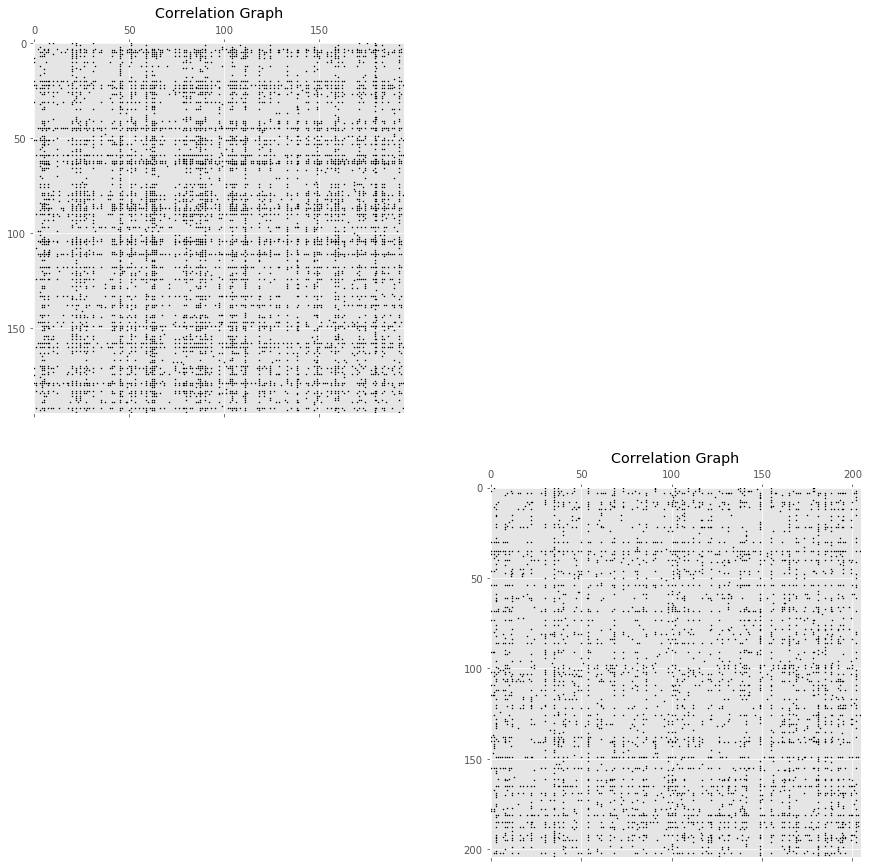

Analyzing component 0 with 205 nodes
Layer 0: M_0 = |V| = 248 nodes (43 added),|E| = 1739 edges
Layer 1: M_1 = |V| = 124 nodes (7 added),|E| = 1259 edges
Layer 2: M_2 = |V| = 62 nodes (1 added),|E| = 738 edges
Layer 3: M_3 = |V| = 31 nodes (0 added),|E| = 322 edges
Analyzing component 1 with 195 nodes
Layer 0: M_0 = |V| = 240 nodes (45 added),|E| = 2851 edges
Layer 1: M_1 = |V| = 120 nodes (7 added),|E| = 1884 edges
Layer 2: M_2 = |V| = 60 nodes (1 added),|E| = 971 edges
Layer 3: M_3 = |V| = 30 nodes (0 added),|E| = 370 edges
NN architecture for component 1
  input: M_0 = 248
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 248 * 10 / 2 = 1240
    weights: F_0 * F_1 * K_1 = 1 * 10 * 35 = 350
    biases: F_1 = 10
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 124 * 10 / 2 = 620
    weights: F_1 * F_2 * K_2 = 10 * 10 * 35 = 3500
    biases: F_2 = 10
  layer 3: fc1
    representation: M_3 = 100
    weights: M_2 * M_3 = 620 * 100 = 62000
    biases: M_3 = 100
  layer 4: l

/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/scratch/mmd/.condaEnvs/gene_expression_modelling/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


  validation accuracy: 26.23 (32 / 122), f1 (weighted): 23.59, loss: 9.23e+00
  time: 8s (wall 6s)
step 200 / 20895 (epoch 2.87 / 300):
  learning_rate = 6.00e-03, loss_average = 8.10e+00
  validation accuracy: 40.16 (49 / 122), f1 (weighted): 36.41, loss: 8.02e+00
  time: 15s (wall 12s)
step 300 / 20895 (epoch 4.31 / 300):
  learning_rate = 6.00e-03, loss_average = 7.11e+00
  validation accuracy: 42.62 (52 / 122), f1 (weighted): 41.51, loss: 7.21e+00
  time: 24s (wall 20s)
step 400 / 20895 (epoch 5.74 / 300):
  learning_rate = 6.00e-03, loss_average = 6.36e+00
  validation accuracy: 45.90 (56 / 122), f1 (weighted): 43.00, loss: 6.46e+00
  time: 32s (wall 27s)
step 500 / 20895 (epoch 7.18 / 300):
  learning_rate = 5.88e-03, loss_average = 5.66e+00
  validation accuracy: 48.36 (59 / 122), f1 (weighted): 48.34, loss: 5.97e+00
  time: 43s (wall 36s)
step 600 / 20895 (epoch 8.61 / 300):
  learning_rate = 5.88e-03, loss_average = 5.09e+00
  validation accuracy: 47.54 (58 / 122), f1 (weighte

In [ ]:
update_params = {
    'dir_name': 'gcnn_drug_classifier_corr_multicomp',
    # Architecture.
    'Fs': [[10, 10], [10, 10]],  # Number of graph convolutional filters.
    'Ks': [[35, 35], [35, 35]],  # Polynomial orders.
    'ps': [[2, 2], [2, 2]],    # Pooling sizes.
    'M': [100, max(drug_y) + 1],  # Output dimensionality of fully connected layers.

    # Optimization.
    'regularization': 1e-2,
    'dropout': 0.5,
    'learning_rate': 6e-3,
    'decay_rate': 0.98,
    'momentum': 0.9,
}
res = train_graph_net(X_corr, drug_y, corr_components, corr_nodelists, corr_disconnected_nodes,
                     update_params=update_params)

# Compare Classifiers

In [47]:
# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size
clfs, accs = [], {}

In [56]:
# Classifier Constructors
clf_constructors = [
    ('Logistic Regressor',           LogisticRegression,     {'C': 0.1},            ()),
    ('Random Forest',                RandomForestClassifier, {'n_estimators': 400}, ()),
    ('SKlearn Fully Connected ANN',  MLPClassifier,          {'alpha': 4},          ()),
    ('Correlational Graph Conv ANN', models.cgcnn,           corr_params,           (L_corr, )),
    ('Regulatory Graph Conv ANN',    models.cgcnn,           reg_params,            (L_reg, )),
#    ('Naive Bayes',                  GaussianNB,             {}),
#    ('K-neighbors',                  KNeighborsClassifier,   {'n_neighbors': 20}),
#    ('Decision Tree',                DecisionTreeClassifier, {'max_depth': 5}),
#    ('Linear SVC',                   LinearSVC,              {'C': 0.5}),
#    ('RBF SVC',                      SVC,                    {'C': 0.9, 'kernel': 'rbf'}),
#    ('AdaBoost',                     AdaBoostClassifier,     {}),
]
# Discarded Classifiers:
#38% Acc. (drug) (GaussianNB(),                                               'Naive Bayes'),
#30% Acc. (drug) (KNeighborsClassifier(n_neighbors=20),                       'K-neighbors'),
#15% Acc. (drug) (DecisionTreeClassifier(max_depth=5),                        'Decision Tree'),
#43% Acc. (drug) (LinearSVC(C=0.5),                                          'Linear Support Vector Classification'),
#34% Acc. (drug) (SVC(C=0.9),                                                 'RBF Support Vector Classification'),
#12% Acc. (drug) (AdaBoostClassifier(),                                       'AdaBoost'),
#1% Acc.  (drug) (GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True), 'Gaussian Processes'),
#3% Acc.  (drug) (QuadraticDiscriminantAnalysis(),                            'Quadratic Discriminat Analysis'),

In [60]:

def build_and_train(clf_constructors=clf_constructors, clfs_to_train='ALL', old_clfs=clfs, old_accs=accs):
    if clfs_to_train == 'ALL': clfs_to_train = range(len(clf_constructors))
    if len(clfs_to_train) == 0: return old_clfs, {}
    
    if old_clfs == []: new_clfs = [(None, 'NULL')] * len(clf_constructors)
    else: new_clfs = old_clfs
        
    new_accs = old_accs
    for idx in clfs_to_train:
        name, fn, kwargs, posargs = clf_constructors[idx]
        clf = fn(*posargs, **kwargs)
        start = time.perf_counter()
        print('Training %s' % name)
        if type(clf) == lib.models.cgcnn:
            acc = None
            if 'Regulatory' in name:
                acc = clf.fit(X_train_reg, y_train, X_val_reg, y_val)
            elif 'Correlation' in name:
                acc = clf.fit(X_train_corr, y_train, X_val_corr, y_val)
            else:
                acc = clf.fit(X_train.values, y_train, X_val.values, y_val)
            new_accs[name] = acc
        else:
            clf.fit(X_train, y_train)
        print('%s trained! Took %s' % (name, str(time.perf_counter() - start)))
        
        new_clfs[idx] = (clf, name)
        
    return new_clfs, new_accs

In [105]:
clfs, accs = build_and_train(clfs_to_train='ALL')

NameError: name 'build_and_train' is not defined

# 4 Evaluation


The `model_perf` class in [utils.py](utils.py) can be used to compactly evaluate multiple models.

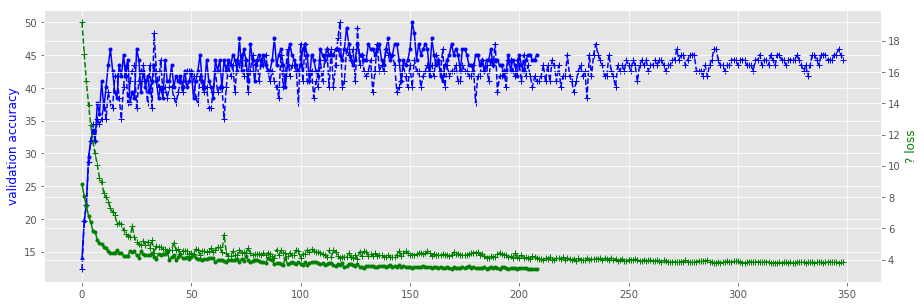

In [62]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accs['Correlational Graph Conv ANN'][0], 'b.-')
ax1.plot(accs['Regulatory Graph Conv ANN'][0], 'b+--')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(accs['Correlational Graph Conv ANN'][1], 'g.-')
ax2.plot(accs['Regulatory Graph Conv ANN'][1], 'g+--')
ax2.set_ylabel('? loss', color='g')
plt.show()

In [63]:
for clf, name in clfs:
    print(name)
    if type(clf) != lib.models.cgcnn:
        print('%.2f %%' % (100.0*clf.score(X_test, y_test)))
    elif 'Correlational' in name:
        res = clf.evaluate(X_test_corr, y_test)
        print('%.2f %%' % res[1])
    elif 'Regulatory' in name:
        res = clf.evaluate(X_test_reg, y_test)
        print('%.2f %%' % res[1])

if C == 2: calibration_curve(clfs)

Logistic Regressor
47.49 %
Random Forest
43.27 %
SKlearn Fully Connected ANN
50.40 %
Correlational Graph Conv ANN
INFO:tensorflow:Restoring parameters from /scratch/mmd/cnn_graph/lib/../checkpoints/gcnn_drug_classifier_corr/model-20895
43.80 %
Regulatory Graph Conv ANN
INFO:tensorflow:Restoring parameters from /scratch/mmd/cnn_graph/lib/../checkpoints/gcnn_drug_classifier_reg/model-34825
45.65 %
